<center><img src="https://www.inf.utfsm.cl/images/slides/Departamento-de-Informtica_HORIZONTAL.png" title="Title text" width= 800 /></center>
<hr style="height:2px;border:none"/>
<H1 align='center'> DESAFÍO TAREA 1</H1>

<H3 align='center'> INF395 2023-2 </H3>
<hr style="height:2px;border:none"/>

## Integrantes:
* Joaquín Aguirre (201910031-9)
* Alejandro Villazón (201910009-2)
* Dominique Yessouroun (201910005-K)

Importamos las librerías necesarias:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

import os
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.neighbors import NearestNeighbors

import warnings

# Ignorar las advertencias
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Helper functions

In [2]:
def rellenar_new(train, modificar, k=5, ponderado = False):
    '''
    Rellenamos columna por columna los datos faltantes con el valor del promedio
    de los 'k' vecinos más cercanos no nulos según latitud 'la' y longitud 'long',
    Si ponderado = True se asigna más peso a las observaciones más cercanas según 1/distancia,
    salvo si hay una distancia = 0, en ese caso se asigna el valor de esa observación.
    Si ponderado = False, se calcula el promedio clásico de los valores.
    '''
    mod = modificar.copy()
    for columna in mod.columns[mod.isna().any()]:
        aux = train.copy().dropna(subset=[columna]).reset_index(drop=True)
        nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(aux[["lat","long"]])
        for id_x,fila in mod[mod[columna].isna()].iterrows(): 
            distances, indices = nbrs.kneighbors(fila[["lat","long"]].values.reshape(1, 2))
            if ponderado:
                if distances[0][0] == 0:
                    mod.loc[id_x,columna] = aux.loc[indices[0], columna].values[0]
                else:
                    mod.loc[id_x,columna] = np.dot(aux.loc[indices[0], columna].values, 1/distances[0]) / np.sum(1/distances[0])
            else:
                mod.loc[id_x,columna] = aux.loc[indices[0], columna].mean()
    return mod


In [3]:
def preprocess_time(df, column, period):
    df['sin_'+column] = np.sin(2 * np.pi * df[column] / period)
    df['cos_'+column] = np.cos(2 * np.pi * df[column] / period)
    df.drop([column], axis=1, inplace=True)
    return df

In [4]:
def plot_losses(history, loss):
    "Función para graficar la función de pérdida del modelo"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Error Graph')
    plt.ylabel(loss.name)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Descargamos los datos:

In [5]:
df = pd.read_csv('/kaggle/input/inf-395-tarea-1/data_kaggle/data/train_data.csv', index_col="ID")
x_test =  pd.read_csv('/kaggle/input/inf-395-tarea-1/data_kaggle/data/test_data.csv',index_col="ID")

In [6]:
sample_submisssion = pd.read_csv('/kaggle/input/inf-395-tarea-1/data_kaggle/sample_submission.csv')
sample_submisssion

,ID,price
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
315,315,0
316,316,0
317,317,0
318,318,0


Exploremos los datos:

In [7]:
def datainfo(data):
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100
    return temp_ps

df_info = datainfo(df)
df_info

,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
date,object,1276,280,0,0.000000
zipcode,int64,1276,66,0,0.000000
lat,float64,1276,1000,0,0.000000
long,float64,1276,408,0,0.000000
bedrooms,float64,1074,10,202,15.830721
bathrooms,float64,1079,22,197,15.438871
sqft_living,float64,1082,366,194,15.203762
sqft_lot,float64,1087,870,189,14.811912
floors,float64,1084,5,192,15.047022
waterfront,float64,1076,2,200,15.673981


Observamos que todas las variables son numéricas, salvo la fecha, que es tipo object (generalización de str). Además, notamos que tenemos presencia de datos faltantes.

In [9]:
df_info.query('NaN_Values > 0')[['NaN_Values']]

,NaN_Values
bedrooms,202
bathrooms,197
sqft_living,194
sqft_lot,189
floors,192
waterfront,200
view,194
condition,181
grade,190
sqft_above,187


In [11]:
df_info.query('NaN_Values > 0')[['NaN_Values_Percentage']]

,NaN_Values_Percentage
bedrooms,15.830721
bathrooms,15.438871
sqft_living,15.203762
sqft_lot,14.811912
floors,15.047022
waterfront,15.673981
view,15.203762
condition,14.184953
grade,14.890282
sqft_above,14.655172


Se tiene un problema grave de datos faltantes debido a que en varias variables se tiene que alrededor del 15% toma valor nulo. Más adelante en el notebook se abordará este problema.

# Exploración de features

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
zipcode,1276.0,98076.235110,54.734005,98001.0000,98029.000,98059.0000,98117.00000,9.819900e+04
lat,1276.0,47.567730,0.137067,47.1622,47.492,47.5882,47.68130,4.777750e+01
long,1276.0,-122.207464,0.147224,-122.5110,-122.339,-122.2150,-122.10975,-1.214020e+02
bedrooms,1074.0,3.388268,0.937513,1.0000,3.000,3.0000,4.00000,1.000000e+01
bathrooms,1079.0,2.148054,0.853977,0.0000,1.500,2.2500,2.50000,7.500000e+00
sqft_living,1082.0,2140.665434,977.118984,540.0000,1420.000,1990.0000,2620.00000,7.000000e+03
sqft_lot,1087.0,22913.940202,52877.670777,638.0000,5383.000,8145.0000,14578.50000,7.156900e+05
floors,1084.0,1.496771,0.534790,1.0000,1.000,1.5000,2.00000,3.000000e+00
waterfront,1076.0,0.011152,0.105063,0.0000,0.000,0.0000,0.00000,1.000000e+00
view,1082.0,0.252311,0.811640,0.0000,0.000,0.0000,0.00000,4.000000e+00


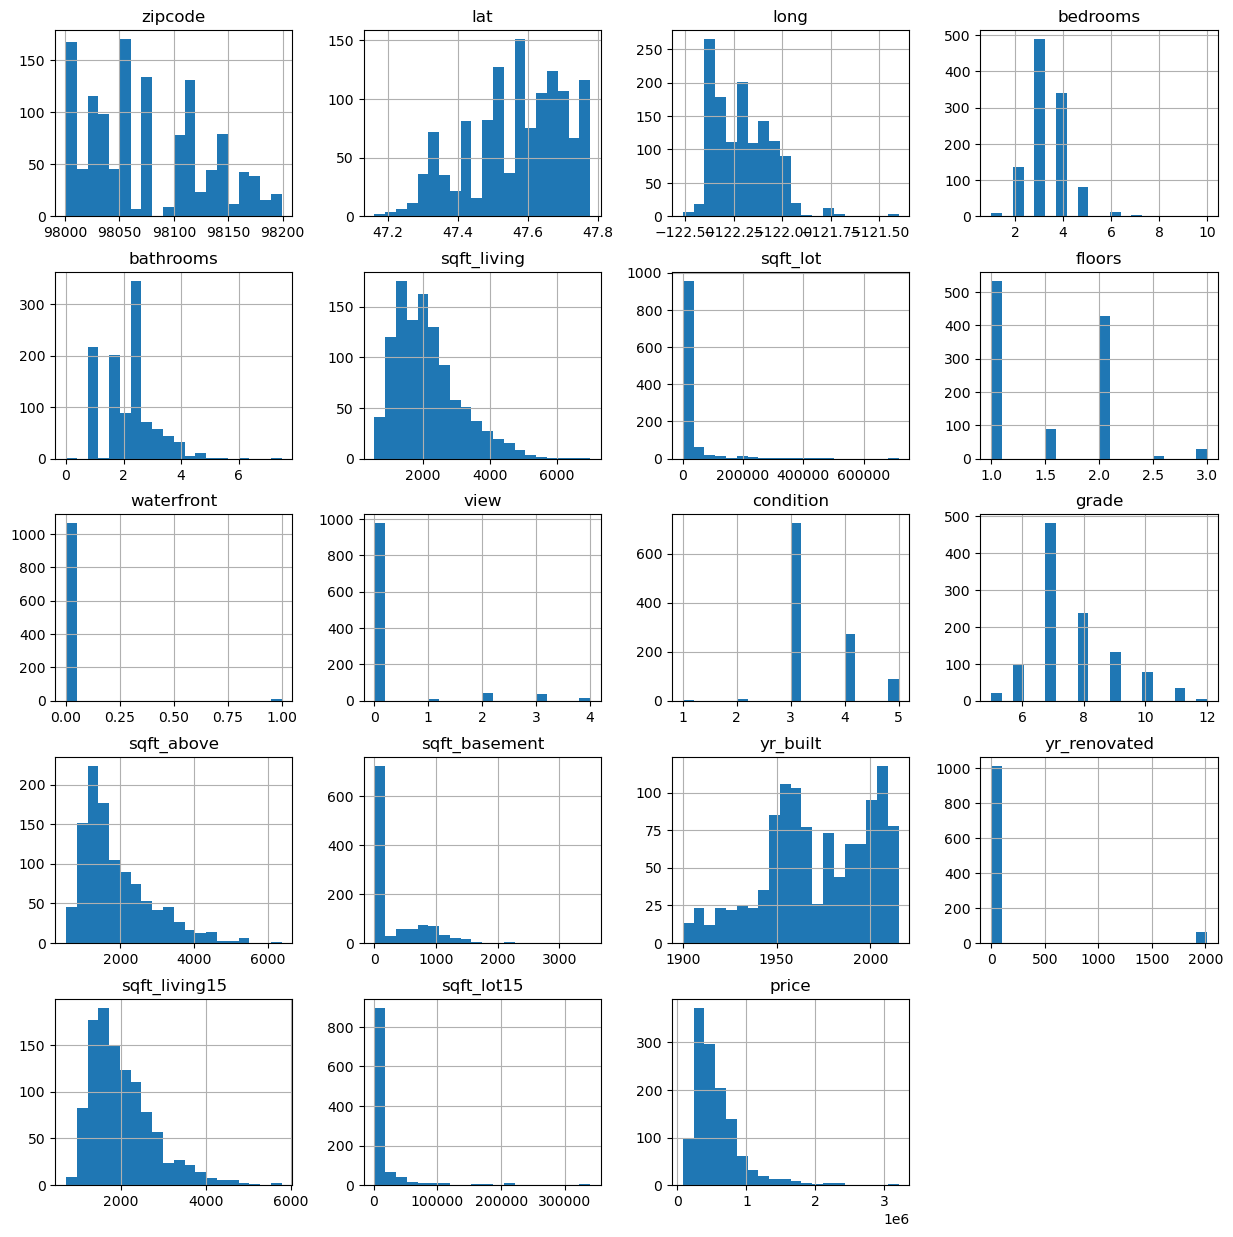

In [13]:
df.hist(figsize=(15,15), layout=(5,4), bins=20);

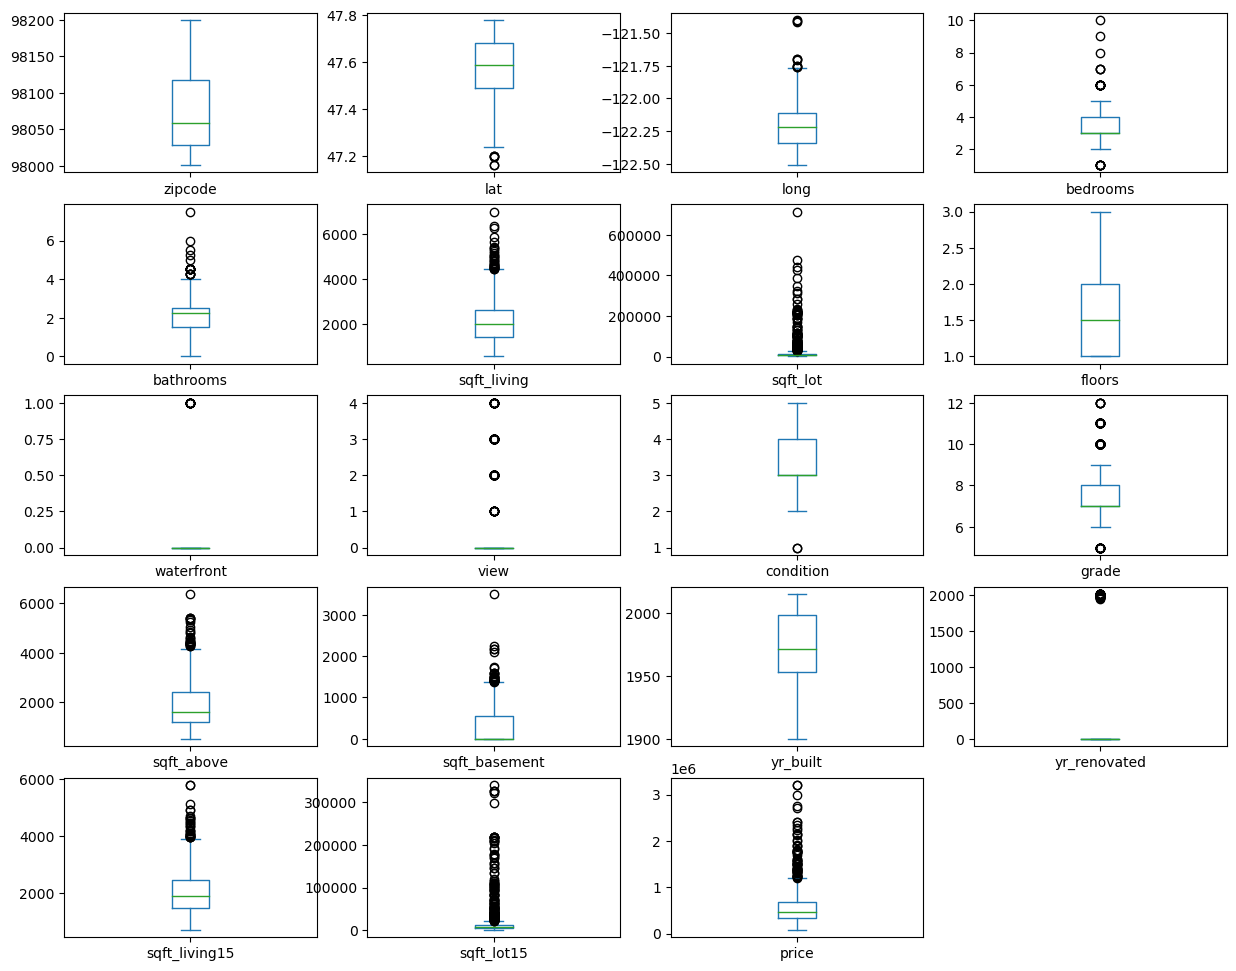

In [17]:
df.plot(kind="box",
        subplots=True,
        layout=(5,4),
        figsize=(15,12),
        );

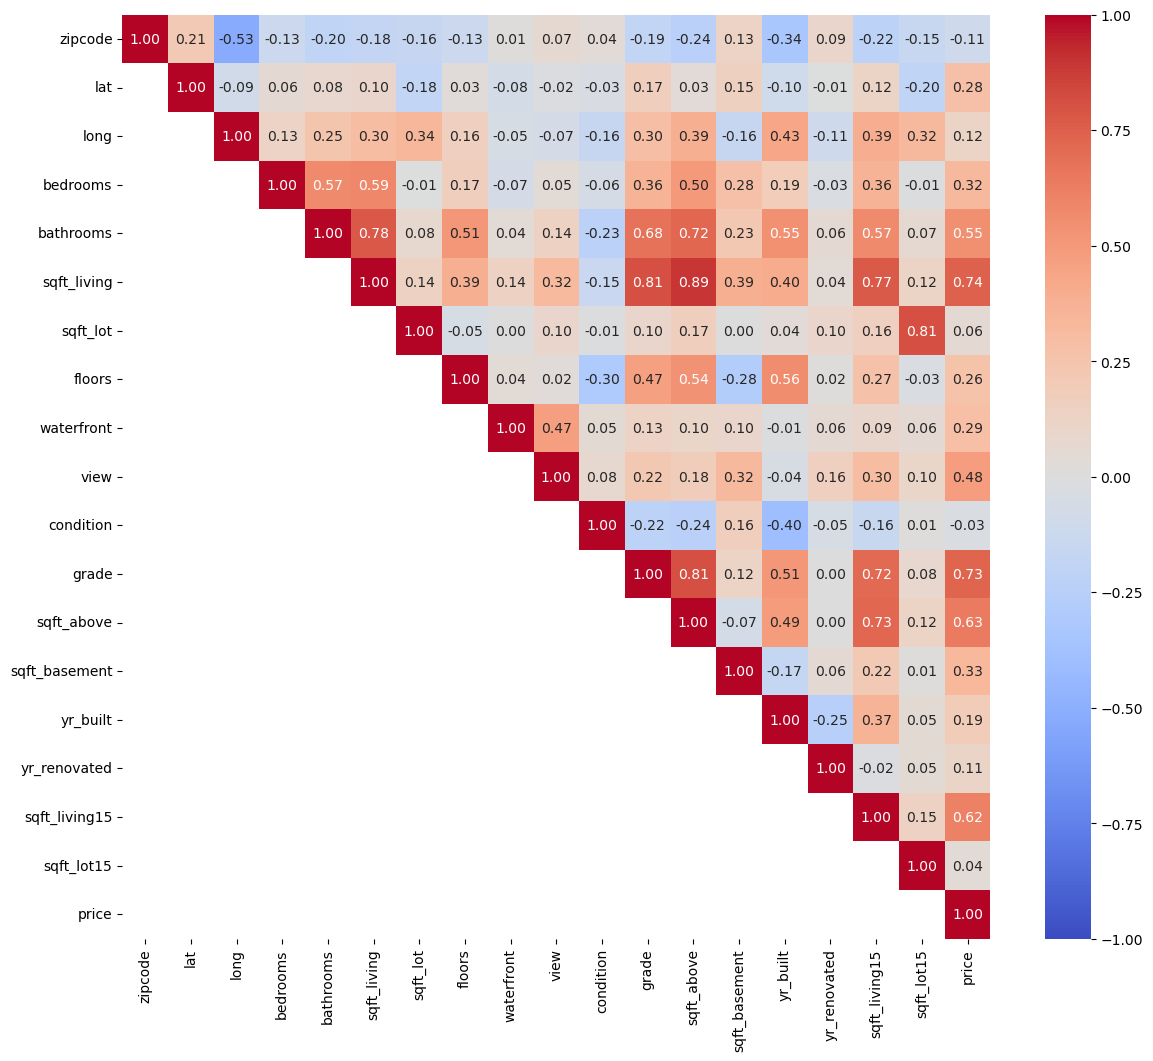

In [19]:
mask = np.tril(np.ones_like(df.corr(numeric_only=True), dtype=bool), k = -1)
plt.figure(figsize = (14,12))

sns.heatmap(df.corr(numeric_only=True), annot = True, vmin = -1, vmax = 1, cmap = 'coolwarm', mask = mask, fmt = '.2f');

De un análisis rápido notamos que las variables tienen rangos de distintos ordenes, por lo que estandarizaremos los datos antes de entrenar los modelos. De los gráficos, notamos que algunas variables presentan outliers, lo cual puede deberse a casas fuera de lo 'común' como 'mansiones'. La distribución de algunas variables son muy desbalanceadas, cargadas a cierto extremo. 

# Feature Engineering

Transformaremos la variable `date` a año, mes, dia del año, asumiendo que son 365 días por año.

In [22]:
df[["date"]]

KeyError: "None of [Index(['date'], dtype='object')] are in the [columns]"

In [21]:
df["date"] = pd.to_datetime(df["date"])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.dayofyear
df = df.drop(columns=['date'])

df.head()

,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price,year,month,day
ID,,,,,,,,,,,,,,,,,,,,,
143,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,0.0,0.0,...,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0,2014,5,135
1175,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,0.0,0.0,...,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0,2014,12,337
221,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,0.0,0.0,...,640.0,0.0,1942.0,0.0,NaN,7424.0,165000.0,2014,7,192
1231,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,0.0,0.0,...,1080.0,160.0,NaN,0.0,1530.0,1209.0,403000.0,2014,11,321
509,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,0.0,NaN,...,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0,2015,4,92


Realizamos el mismo procedimiento al conjunto de prueba.

In [23]:
x_test["date"] = pd.to_datetime(x_test["date"])
x_test['year'] = x_test['date'].dt.year
x_test['month'] = x_test['date'].dt.month
x_test['day'] = x_test['date'].dt.dayofyear
x_test = x_test.drop(columns=['date'])

x_test.head()

,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,year,month,day
ID,,,,,,,,,,,,,,,,,,,,,
1473,98006,47.5544,-122.147,NaN,4.50,4490.0,24767.0,2.0,0.0,2.0,...,NaN,3800.0,690.0,1998.0,0.0,3370.0,32700.0,2015,4,111
716,98030,47.3573,-122.200,3.0,NaN,1730.0,6007.0,NaN,0.0,0.0,...,8.0,NaN,0.0,NaN,0.0,2000.0,6245.0,2014,10,302
1360,98074,47.6085,-122.013,4.0,2.50,3720.0,8633.0,2.0,0.0,0.0,...,10.0,3720.0,0.0,1999.0,NaN,3515.0,9660.0,2014,12,351
1522,98027,47.4913,-122.081,4.0,2.50,2550.0,NaN,2.0,0.0,0.0,...,9.0,2550.0,0.0,2001.0,0.0,1870.0,56628.0,2014,7,196
1570,98146,47.4982,-122.362,1.0,0.75,480.0,9750.0,1.0,0.0,0.0,...,4.0,480.0,0.0,1948.0,0.0,1550.0,9924.0,2014,8,237


Dada la periodicidad de las variables temporales, las transformamos a variables cíclicas con representación seno-coseno.

In [24]:
#Pasar los datos ciclicos a seno y coseno.

df = preprocess_time(df,"day",365)
df = preprocess_time(df,"month",12)
x_test = preprocess_time(x_test,"day",365)
x_test = preprocess_time(x_test,"month",12)

df.head()

,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,sqft_living15,sqft_lot15,price,year,sin_day,cos_day,sin_month,cos_month
ID,,,,,,,,,,,,,,,,,,,,,
143,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,0.0,0.0,...,1991.0,0.0,1590.0,7606.0,263000.0,2014,0.729558,-0.683919,5.000000e-01,-0.866025
1175,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,0.0,0.0,...,1930.0,0.0,1380.0,4005.0,620000.0,2014,-0.463550,0.886071,-2.449294e-16,1.000000
221,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,0.0,0.0,...,1942.0,0.0,NaN,7424.0,165000.0,2014,-0.162807,-0.986658,-5.000000e-01,-0.866025
1231,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,0.0,0.0,...,NaN,0.0,1530.0,1209.0,403000.0,2014,-0.687053,0.726608,-5.000000e-01,0.866025
509,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,0.0,NaN,...,2010.0,0.0,2580.0,3800.0,318200.0,2015,0.999917,-0.012910,8.660254e-01,-0.500000


# Datos faltantes
Dado que tenemos gran cantidad de datos faltantes en diferentes columnas, teorizamos que casas cercanas debiesen tener características similares, dada la idea anterior, rellenamos datos faltantes utilizando KNN mediante la función rellenar() que columna por columna busca los K vecinos más cercanos en el train set sin valores nulos en la columna y calcula el promedio ponderado para rellenar el valor faltante.

In [25]:
x_test = rellenar_new(df,x_test,5,True)
x_test.head()

,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,year,sin_day,cos_day,sin_month,cos_month
ID,,,,,,,,,,,,,,,,,,,,,
1473,98006,47.5544,-122.147,4.779035,4.500000,4490.0,24767.000000,2.0,0.0,2.0,...,690.0,1998.000000,0.0,3370.0,32700.0,2015,0.942761,-0.333469,8.660254e-01,-0.500000
716,98030,47.3573,-122.200,3.000000,2.457894,1730.0,6007.000000,2.0,0.0,0.0,...,0.0,2010.550178,0.0,2000.0,6245.0,2014,-0.884068,0.467359,-8.660254e-01,0.500000
1360,98074,47.6085,-122.013,4.000000,2.500000,3720.0,8633.000000,2.0,0.0,0.0,...,0.0,1999.000000,0.0,3515.0,9660.0,2014,-0.238673,0.971100,-2.449294e-16,1.000000
1522,98027,47.4913,-122.081,4.000000,2.500000,2550.0,63567.019422,2.0,0.0,0.0,...,0.0,2001.000000,0.0,1870.0,56628.0,2014,-0.230306,-0.973118,-5.000000e-01,-0.866025
1570,98146,47.4982,-122.362,1.000000,0.750000,480.0,9750.000000,1.0,0.0,0.0,...,0.0,1948.000000,0.0,1550.0,9924.0,2014,-0.806480,-0.591261,-8.660254e-01,-0.500000


In [26]:
df = rellenar_new(df,df,5,True)
df.head()

,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,sqft_living15,sqft_lot15,price,year,sin_day,cos_day,sin_month,cos_month
ID,,,,,,,,,,,,,,,,,,,,,
143,98003,47.2857,-122.300,3.0,2.250000,1590.0,7748.000000,2.000000,0.0,0.0,...,1991.000000,0.0,1590.000000,7606.0,263000.0,2014,0.729558,-0.683919,5.000000e-01,-0.866025
1175,98117,47.6885,-122.380,3.0,1.404438,2040.0,4005.000000,1.518923,0.0,0.0,...,1930.000000,0.0,1380.000000,4005.0,620000.0,2014,-0.463550,0.886071,-2.449294e-16,1.000000
221,98106,47.5150,-122.359,2.0,1.000000,640.0,7768.000000,1.000000,0.0,0.0,...,1942.000000,0.0,1462.373798,7424.0,165000.0,2014,-0.162807,-0.986658,-5.000000e-01,-0.866025
1231,98144,47.5758,-122.309,2.0,1.500000,1240.0,2388.376462,1.197531,0.0,0.0,...,1918.845535,0.0,1530.000000,1209.0,403000.0,2014,-0.687053,0.726608,-5.000000e-01,0.866025
509,98038,47.3531,-122.017,3.0,2.727740,1990.0,3764.104743,2.000000,0.0,0.0,...,2010.000000,0.0,2580.000000,3800.0,318200.0,2015,0.999917,-0.012910,8.660254e-01,-0.500000


# Separación de conjuntos

In [27]:
X = df.drop(['price'], axis = 1)
y = df['price']

Dada la alta variabilidad de las variables (rango), las estandarizaremos.

In [28]:
y_scaler = StandardScaler()
X_scaler = StandardScaler()

y = y_scaler.fit_transform(np.array(y).reshape(-1, 1))
X[X.columns] = X_scaler.fit_transform(X[X.columns])

x_test[x_test.columns] = X_scaler.transform(x_test[x_test.columns])

Ajustemos una primera NN simple.

In [29]:
#Un modelo simple de redes neuronales FeedForward

inputs = keras.Input(shape=(X.shape[1]))
x =  keras.layers.Dense(256, activation='relu')(inputs)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x =  keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)
x =  keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 dense (Dense)               (None, 256)               6144      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080  

In [30]:
loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error"])

In [31]:
epochs = 200
batch_size = 128
val_split = 0.1
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
] #si va a implementar early stopping, asegurese de retornar los mejores pesos

In [32]:
history = model.fit(X,
                    y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=val_split,
                    callbacks=my_callbacks,
                    verbose=2)

Epoch 1/200
9/9 - 2s - loss: 0.6179 - mean_squared_error: 0.6179 - val_loss: 0.5446 - val_mean_squared_error: 0.5446 - 2s/epoch - 200ms/step
Epoch 2/200
9/9 - 0s - loss: 0.3476 - mean_squared_error: 0.3476 - val_loss: 0.4666 - val_mean_squared_error: 0.4666 - 69ms/epoch - 8ms/step
Epoch 3/200
9/9 - 0s - loss: 0.2525 - mean_squared_error: 0.2525 - val_loss: 0.4379 - val_mean_squared_error: 0.4379 - 69ms/epoch - 8ms/step
Epoch 4/200
9/9 - 0s - loss: 0.2324 - mean_squared_error: 0.2324 - val_loss: 0.4106 - val_mean_squared_error: 0.4106 - 70ms/epoch - 8ms/step
Epoch 5/200
9/9 - 0s - loss: 0.2132 - mean_squared_error: 0.2132 - val_loss: 0.3769 - val_mean_squared_error: 0.3769 - 86ms/epoch - 10ms/step
Epoch 6/200
9/9 - 0s - loss: 0.1984 - mean_squared_error: 0.1984 - val_loss: 0.3598 - val_mean_squared_error: 0.3598 - 72ms/epoch - 8ms/step
Epoch 7/200
9/9 - 0s - loss: 0.2005 - mean_squared_error: 0.2005 - val_loss: 0.3553 - val_mean_squared_error: 0.3553 - 88ms/epoch - 10ms/step
Epoch 8/200

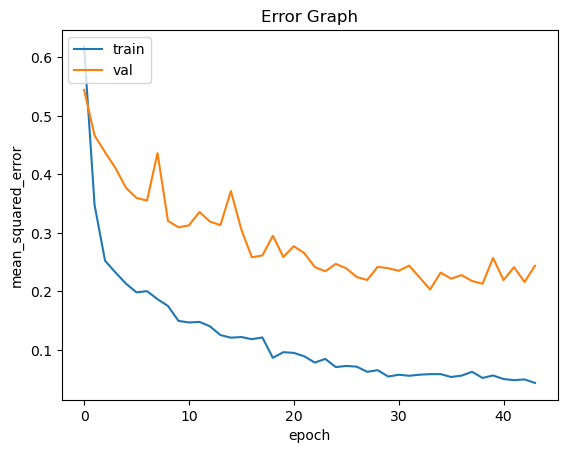

In [33]:
plot_losses(history, loss)

In [34]:
prediccion = y_scaler.inverse_transform(model.predict(x_test, verbose = 0))
prediccion

array([[1592017.2 ],
       [ 311778.47],
       [ 878731.5 ],
       [ 654858.6 ],
       [ 136899.67],
       [ 479940.78],
       [ 344825.66],
       [ 629379.3 ],
       [ 691743.8 ],
       [ 370684.25],
       [ 553590.25],
       [ 767100.44],
       [ 444964.1 ],
       [ 531437.5 ],
       [ 561626.75],
       [ 860803.56],
       [ 400342.44],
       [ 384985.2 ],
       [ 352440.94],
       [ 692973.7 ],
       [ 544059.44],
       [ 424962.16],
       [ 464431.47],
       [ 228763.64],
       [ 500763.3 ],
       [ 526301.2 ],
       [ 369148.8 ],
       [1264411.5 ],
       [ 528937.44],
       [ 404114.12],
       [ 548340.3 ],
       [ 477857.5 ],
       [ 609229.  ],
       [ 627004.56],
       [ 388365.7 ],
       [ 275284.84],
       [ 343331.  ],
       [ 630494.6 ],
       [ 525147.94],
       [ 331752.9 ],
       [ 769857.  ],
       [ 446140.72],
       [ 361340.66],
       [ 354545.34],
       [ 683335.4 ],
       [ 710130.5 ],
       [ 736204.3 ],
       [ 4525

In [35]:
x_test = x_test.reset_index()
x_test['price'] = prediccion
sample_submisssion = x_test[['ID', 'price']]
sample_submisssion

,ID,price
0,1473,1.592017e+06
1,716,3.117785e+05
2,1360,8.787315e+05
3,1522,6.548586e+05
4,1570,1.368997e+05
...,...,...
315,1475,4.415788e+05
316,374,5.901629e+05
317,795,6.344862e+05
318,888,2.727842e+05


In [36]:
sample_submisssion.to_csv('/kaggle/working/sample_submission.csv', index = False)

In [37]:
model.save('/kaggle/working/desafio.keras')